# Introduction

In this notebook, we use Amazon Textract and Google Vision to provide a quick way of extracting text/tables from an image of a page.

Intended use: The intended use of this notebook is to quickly prototype. You should expect to modify the code in this notebook to suit your usecase.

Preparation: At a minimum, set a working folder, and make sure to add your API keys for both Textract and Google Vision. To do so, please follow the steps outlined here: https://github.com/MikeJGiordano/OCR_History/blob/main/ReadMe.md

This notebook contains four parts:

    1. Unmodified image OCR. This is intended to quickly detect text from a single image.
        a. There is then an option to run one or both OCR tools on a whole folder.
        
    2. Image preprocessing. This routine helps you to quickly preprocess a single image (adjust contrast, split image, etc). 
        a. If you are satisfied with the preprocessing routine, it will give you the option to preprocess a whole folder.
        
    3. Image preprocessing with text extraction. This runs the image modification from part 2 into the text detection from part 1.
    
    4. Image preprocessing with table extraction from Textract. This uses the image modification from part 2 to extract a table using Textract.

# Program Setup

## There are 5 steps, marked A-E.

### A: Import packages

In [1]:
import io
import json
import os

# if you don't have these packages use any package manager to install
# you can install all packages at once using the provided requirements.txt file
import cv2
import boto3
from google.cloud import vision

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm as tq

from PIL import Image, ImageDraw
from textractor import Textractor
from textractor.visualizers.entitylist import EntityList
from textractor.data.constants import TextractFeatures, Direction, DirectionalFinderType

# note: the following py file, you'll have to download
import preprocess as pp

### B: Please set your working directories here

In [2]:
# please set the path to the folder containing your images here
input_folder = "/mnt/c/Users/WATLINGS/Documents/OCR Files/Census Processing/Documents/1930/Output"  # relative path since we're already in the correct directory
# please set the path to a desired output folder here
output_folder = "/mnt/c/Users/WATLINGS/Documents/OCR Files/Census Processing/Documents/1930/Output_OCR"

### C: Please set your main input file here

In [ ]:
# set the filename to your image here
#newspaper_image = "1920.png"

### D: Please authenticate Google Cloud

For help with Google Cloud, see https://github.com/MikeJGiordano/OCR_History/blob/main/Setup_Google_Cloud.md

In [3]:
#Authenticate Google Cloud here

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/mnt/c/Users/WATLINGS/Documents/GitHub/OCR_History/OCR_Python/ServiceAccountToken.json'
client = vision.ImageAnnotatorClient()

### E: Please authenticate Amazon Textract

For help with Amazon Textract, see https://github.com/MikeJGiordano/OCR_History/blob/main/Setup_AWS_Root.md

In [ ]:
#Authenticate AWS Textract in the console/terminal

# Part 1: Basic text extraction

In [ ]:
# plot the image, save .json outputs
#pp.process_content(newspaper_image, 
#                  input_folder,
#                  output_folder,
#                  show_image=True,
#                   use_google_vision=True, 
#                   use_textract=True, 
#                   verbose=True) 

### You can use the next cell to get text and JSON files for the entire input folder through Google Vision, Textract, or both.

In [ ]:
# Batch process all images in the input folder, save text and JSON outputs to the output folder

# pp.batch_ocr(input_folder, 
#                 output_folder, 
#                 use_google_vision=True, 
#                 use_textract=True)

# Part 2: Preprocess images
Often, it helps to preprocess an image. Common routines are:
    
    1. Adjusting contrast or brightness
    2. Converting to grayscale
    3. Cropping
    4. Erasing margins
    5. Splitting images
    
We now provide two examples:
    
    1. Applying points 1-4 
    2. Preprocessing and splitting the image

### Example 1: Full image

In [ ]:
# set the filename to your image heren
census_list = "41129380v6ch01_55.png"

In [ ]:
#The next cell will apply the default preprocess settings to your image.
#If you are unsatisfied with those settings, it will instruct you on how to make changes.
#Those changes should be inserted in this cell.



In [ ]:
pp.default['left_margin_percent'] = 5
pp.default['right_margin_percent'] = 10
pp.default['rotation_angle'] = -0.2
pp.default['vsplit_percent'] = 43.6 
pp.default['top_margin_percent'] = 13
pp.default['bottom_margin_percent'] = 5 # 5% margin from bottom
pp.default['line_thickness'] = 3

#Preprocess a single image.
pp.preprocess_image(census_list,
                   input_folder,
                   output_folder,
                   **pp.default)



### Example 2: Split image

In [ ]:
# set the filename to your split image here
korean_image = "126.png"

In [ ]:
#The next cell will apply the default preprocess settings to your image.
#If you are unsatisfied with those settings, it will provide instructions on how to make changes.

#pp.default['left_margin_percent'] = 30
#pp.default['top_margin_percent'] = 5

In [ ]:
#Preprocess a split image.
pp.preprocess_image(korean_image,
                       input_folder,
                       output_folder,
                       **pp.default);

# Part 3: Preprocessed Text Extraction

### Example 1: Full image

In [ ]:
# using the above processing, the folder of modified images is located at:

modified_images = "output/modified_images/"

# Modification alters the name of the file to be:

modified_railroad = 'modified_' + railroad_table

In [ ]:
# plot the image, save .json outputs
pp.process_content(modified_railroad, 
                   modified_images,
                   output_folder,
                   show_image = True,
                   use_google_vision=False, 
                   use_textract=True, 
                   verbose=True)

### Example 2: Split image

In [ ]:
# Modification splits the file into two and renames them:

modified_1_split = 'modified_1_' + korean_image
modified_2_split = 'modified_2_' + korean_image

In [ ]:
# plot the images, save .json and .txt outputs
pp.process_content(modified_1_split, 
                   modified_images,
                   output_folder,
                   show_image = True,
                   use_google_vision=True, 
                   use_textract=False, 
                   verbose=True)

pp.process_content(modified_2_split, 
                   modified_images,
                   output_folder,
                   show_image = False,
                   use_google_vision=False, 
                   use_textract=False, 
                   verbose=False)

### You can use the next cell to get text and JSON files for the entire folder of modified images through Google Vision, Textract, or both.

In [ ]:
# Batch process all images in the modified folder, save .json outputs to the output folder

pp.batch_ocr(modified_images, 
                 output_folder, 
                 use_google_vision=False, 
                 use_textract=False)

# Part 4: Textract Table Extraction

### Setup

Initialize Textractor client, modify region if required

In [4]:
extractor = Textractor(profile_name="default")

Please specify the image you want to extract a table from.

In [5]:
# using the above processing, the folder of modified images is located at:
census_table = "41129380v6ch01_55.png" 

modified_images = "/mnt/c/Users/WATLINGS/Documents/OCR Files/Census Processing/Documents/1930/Output_OCR/modified_images"

# Modification alters the name of the file to be:
modified_table = 'modified_' + census_table

modified_table_1 = 'modified_1_' + census_table 

modified_table_2 = 'modified_2_' + census_table 

## Extract the tables

/home/samuelwatling/miniconda3/envs/python_work/lib/python3.9/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (135111399 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Image has 135111399 pixels (exceeds 5000000)
Resizing from 10221x13219 to 1966x2542
Image prepared for Textract at '/mnt/c/Users/WATLINGS/Documents/OCR Files/Census Processing/Documents/1930/Output_OCR/textract_sized_modified_41129380v6ch01_55.jpg'
Processing image: modified_41129380v6ch01_55.png
This document holds the following data:
Pages - 1
Words - 1932
Lines - 1793
Key-values - 0
Checkboxes - 0
Tables - 1
Queries - 0
Signatures - 0
Identity Documents - 0
Expense Documents - 0


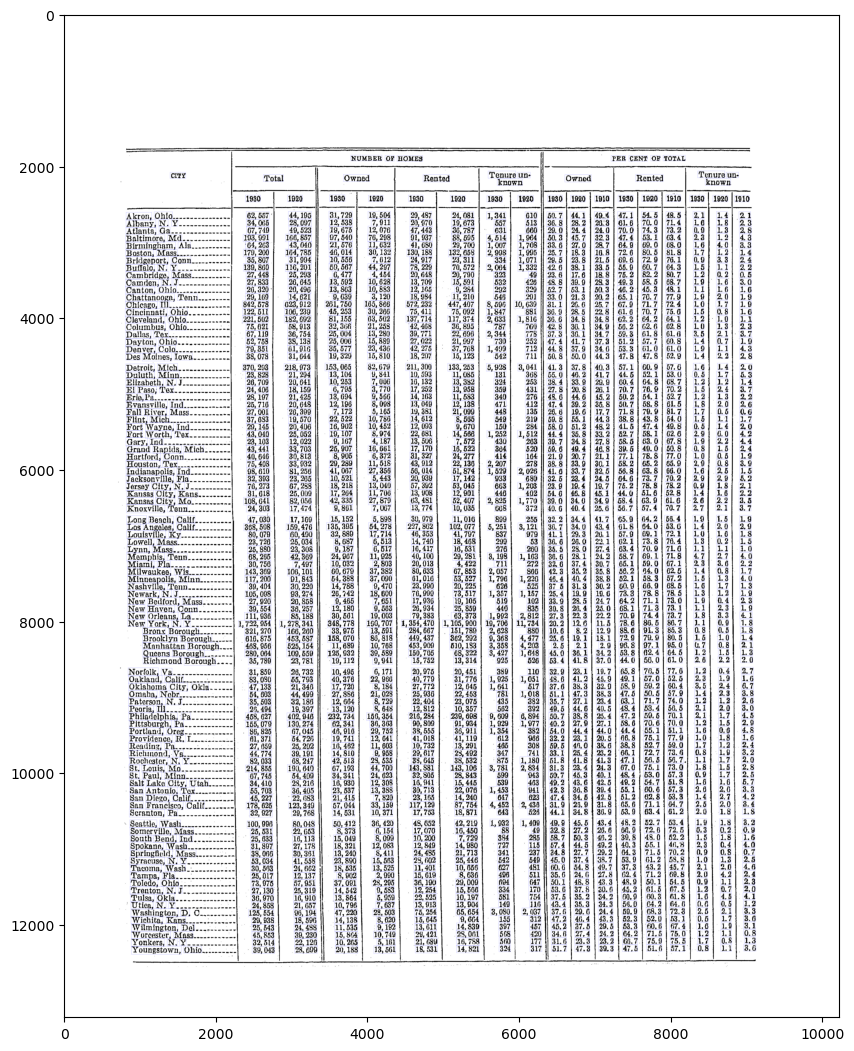

Do you want to see the table output? (y/n):  y


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,CITY,,,,NUMBER OF,HOMES,,,,PER CENT OF TOTAL,,,,,,,,
1,,Total,,Owned,,Rented,,Tenure known,un-,,Owned,,Rented,,,,Tenure un- known,
2,,1930,1920,1930,1920,1930,1920,1930,1920,1930,1920,1910,1930,1920,1910,1930,1920,1910
3,"Akron, Ohio","62,557","44,195","31,729","19,504","29,487","24,081","1,341",010,50.7,"44,1","49.,4",47.1,54.5,48.5,2.1,1.4,2.1
4,"Albany, N. Y","34,065","28,097","12,538","7,911","20,970","19,673",557,513,36.8,28.2,20.3,61.6,70.0,71.4,1.6,1.8,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,"Wilmington, Del","25,543","24,488","11,535","9,192","13,611","14,839",397,457,45.2,37.5,29.5,53.3,60.6,67.4,1.6,1.9,"3,1"
98,"Worcester, Mass","45,853","39,230","15,804","10,749","29,421","28,001",568,420,34.6,27.4,24.2,64.2,71.5,75.0,1.2,"1,1",0.8
99,"Yonkers, N. Y","32,514","22,120","10,265","5,101","21,689","16,788",560,177,31.6,23.3,23.2,66.7,75.9,75.5,1.7,"0,8",1.3
100,"Youngstown, Ohio","39,043","28,699","20,188","13,561","18,531","14,821",324,317,51.7,47.3,39.3,47.5,51.6,57.1,0.8,1.1,"3,6"


Do you want to batch extract the Excel tables from images in the input_folder? (y/n):  n
Do you want to extract the Excel table from this image? (y/n):  y


Excel table saved as modified_41129380v6ch01_55.xlsx in /mnt/c/Users/WATLINGS/Documents/OCR Files/Census Processing/Documents/1930/Output_OCR


In [6]:
pp.extract_table(extractor, 
                       modified_table,
                       modified_images,
                       output_folder);